In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import cv2
import glob
import pathlib
import PIL, PIL.Image
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras import layers
from keras import backend as K
import logging


In [ ]:
base_dir = '/content/drive/MyDrive/Colab Notebooks'
data_dir = os.path.join(base_dir,'EEG_SHCEEEZ-DL','out')
a_dataset = pathlib.Path(os.path.join(data_dir,'A'))

In [ ]:
image_count = len(list(a_dataset.glob('*/*.png')))
print('number of total images:', image_count, '\n\n')

number of total images: 725 




In [ ]:
models_path = os.path.join(base_dir, 'EEG_SCHEEEZ-DL', 'models')


In [ ]:

height = 224
width = 224

def image_read(image_dir):
  src = cv2.imread(image_dir)
  src_rgb = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
  image = cv2.resize(src_rgb, (width, height))
  image = image.astype('float32') / 255.
  return image



def images_from_directory(a_dataset, cat):
  image_list = []
  images_path = os.path.join(a_dataset, cat)
  images_names = [os.path.join(images_path, name) for name in os.listdir(images_path)]
  for image_dir in images_names:
    image = image_read(image_dir)
    image_list.append(image)
  return image_list


norm_list = images_from_directory(a_dataset, 'norm')
sch_list  = images_from_directory(a_dataset, 'sch')

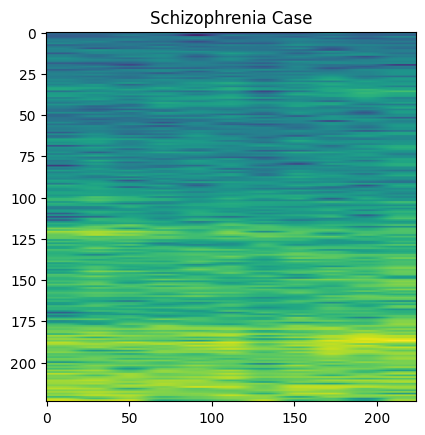

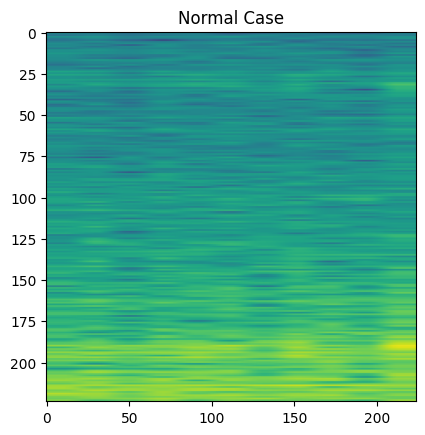

In [ ]:

import matplotlib.pyplot as plt

i = 2
plt.title("Schizophrenia Case")
plt.imshow(sch_list[i])
plt.show()
plt.title("Normal Case")
plt.imshow(norm_list[i])
plt.show()


In [ ]:

print("size of normal image dataset:", len(norm_list))
print("size of schizophrenic dataset:", len(sch_list))
print(norm_list[0].shape)


size of normal image dataset: 348
size of schizophrenic dataset: 377
(224, 224, 3)


In [ ]:
X_norm = np.array(norm_list)
X_sch = np.array(sch_list)

In [ ]:
X_norm.shape, X_sch.shape

((348, 224, 224, 3), (377, 224, 224, 3))

In [ ]:
def train_validation_split(X, ratio=0.2):
  length = int(ratio * X.shape[0])
  return X[length:], X[:length]


X_norm_train, X_norm_valid = train_validation_split(X_norm)
X_sch_train, X_sch_valid = train_validation_split(X_sch)

X_norm_train.shape, X_norm_valid.shape, X_sch_train.shape, X_sch_valid.shape

((279, 224, 224, 3), (69, 224, 224, 3), (302, 224, 224, 3), (75, 224, 224, 3))

In [ ]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)

    plt.figure(figsize=(n_cols, n_rows), dpi=190)
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image)
        plt.axis("off")

In [ ]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [ ]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

latent_dim = 512


def encoder(inputs):
  # (224, 224, 3)

  x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(inputs)
  # (112, 112, 32)

  x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
  # (56, 56, 64)

  x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
  # (28, 28, 128)

  x = layers.Conv2D(256, 3, activation="relu", strides=2, padding="same")(x)
  # (14, 14, 256)

  x = layers.Conv2D(512, 3, activation="relu", strides=2, padding="same")(x)
  # (7, 7, 512)

  x = layers.Flatten()(x)
  x = layers.Dense(1024, activation="relu")(x)
  x = layers.Dense(1024, activation="relu")(x)

  z_mean = layers.Dense(latent_dim, name="z_mean")(x)
  z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
  z = Sampling()([z_mean, z_log_var])
  v_encoder = keras.Model(inputs, [z_mean, z_log_var, z], name="encoder")
  v_encoder.summary()
  return v_encoder, z_log_var, z_mean


def decoder():
  latent_inputs = keras.Input(shape=(latent_dim,))

  x = layers.Dense(1024, activation="relu")(latent_inputs)
  x = layers.Dense(1024, activation="relu")(x)
  x = layers.Dense(7*7*512, activation="relu")(x)
  x = layers.Reshape((7, 7, 512))(x)

  x = layers.Conv2DTranspose(256, 3, activation="relu", strides=2, padding="same")(x)
  # (14, 14, 256)

  x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
  # (28, 28, 128)

  x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
  # (56, 56, 64)

  x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
  # (112, 112, 32)

  decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid",  strides=2, padding="same")(x)
  v_decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
  v_decoder.summary()
  return v_decoder


In [ ]:
inputs = keras.layers.Input(shape=(224, 224, 3))
norm_encoder, norm_codings_log_var, norm_codings_mean = encoder(inputs)
norm_decoder = decoder()
_, _, norm_codings = norm_encoder(inputs)
norm_reconstructions = norm_decoder(norm_codings)
norm_vae = keras.models.Model(inputs=[inputs], outputs=[norm_reconstructions])

latent_loss = -0.5 * K.sum(1 + norm_codings_log_var - K.exp(norm_codings_log_var) - K.square(norm_codings_mean), axis=-1)

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_5 (Conv2D)           (None, 112, 112, 32)         896       ['input_3[0][0]']             
                                                                                                  
 conv2d_6 (Conv2D)           (None, 56, 56, 64)           18496     ['conv2d_5[0][0]']            
                                                                                                  
 conv2d_7 (Conv2D)           (None, 28, 28, 128)          73856     ['conv2d_6[0][0]']            
                                                                                            

In [ ]:
norm_vae.add_loss(K.mean(latent_loss) / (224*224*3))
rms_prop = keras.optimizers.Adam(learning_rate = 0.00008)
norm_vae.compile(loss="binary_crossentropy", optimizer= rms_prop, metrics=[rounded_accuracy])
history = norm_vae.fit(X_norm_train, X_norm_train, epochs=50, batch_size=32, validation_data=(X_norm_valid, X_norm_valid))

Epoch 1/50
9/9 [==============================] - 8s 200ms/step - loss: 0.6931 - rounded_accuracy: 0.5735 - val_loss: 0.6930 - val_rounded_accuracy: 0.6479
Epoch 2/50
9/9 [==============================] - 1s 132ms/step - loss: 0.6929 - rounded_accuracy: 0.6674 - val_loss: 0.6928 - val_rounded_accuracy: 0.6835
Epoch 3/50
9/9 [==============================] - 1s 131ms/step - loss: 0.6927 - rounded_accuracy: 0.6871 - val_loss: 0.6925 - val_rounded_accuracy: 0.6897
Epoch 4/50
9/9 [==============================] - 1s 136ms/step - loss: 0.6924 - rounded_accuracy: 0.6886 - val_loss: 0.6921 - val_rounded_accuracy: 0.6860
Epoch 5/50
9/9 [==============================] - 1s 131ms/step - loss: 0.6918 - rounded_accuracy: 0.6791 - val_loss: 0.6910 - val_rounded_accuracy: 0.6689
Epoch 6/50
9/9 [==============================] - 1s 136ms/step - loss: 0.6894 - rounded_accuracy: 0.6592 - val_loss: 0.6847 - val_rounded_accuracy: 0.6504
Epoch 7/50
9/9 [==============================] - 1s 129ms/step 

In [ ]:
final_accuracy = history.history['rounded_accuracy'][-1]

In [ ]:
print(f"STFT VAE accuracy: {final_accuracy * 100:.2f} %")